In [111]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [112]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [113]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 1 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [114]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 20 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return

Text(0.5, 0.98, 'The effect of strong localized noise on the first 5 channels')

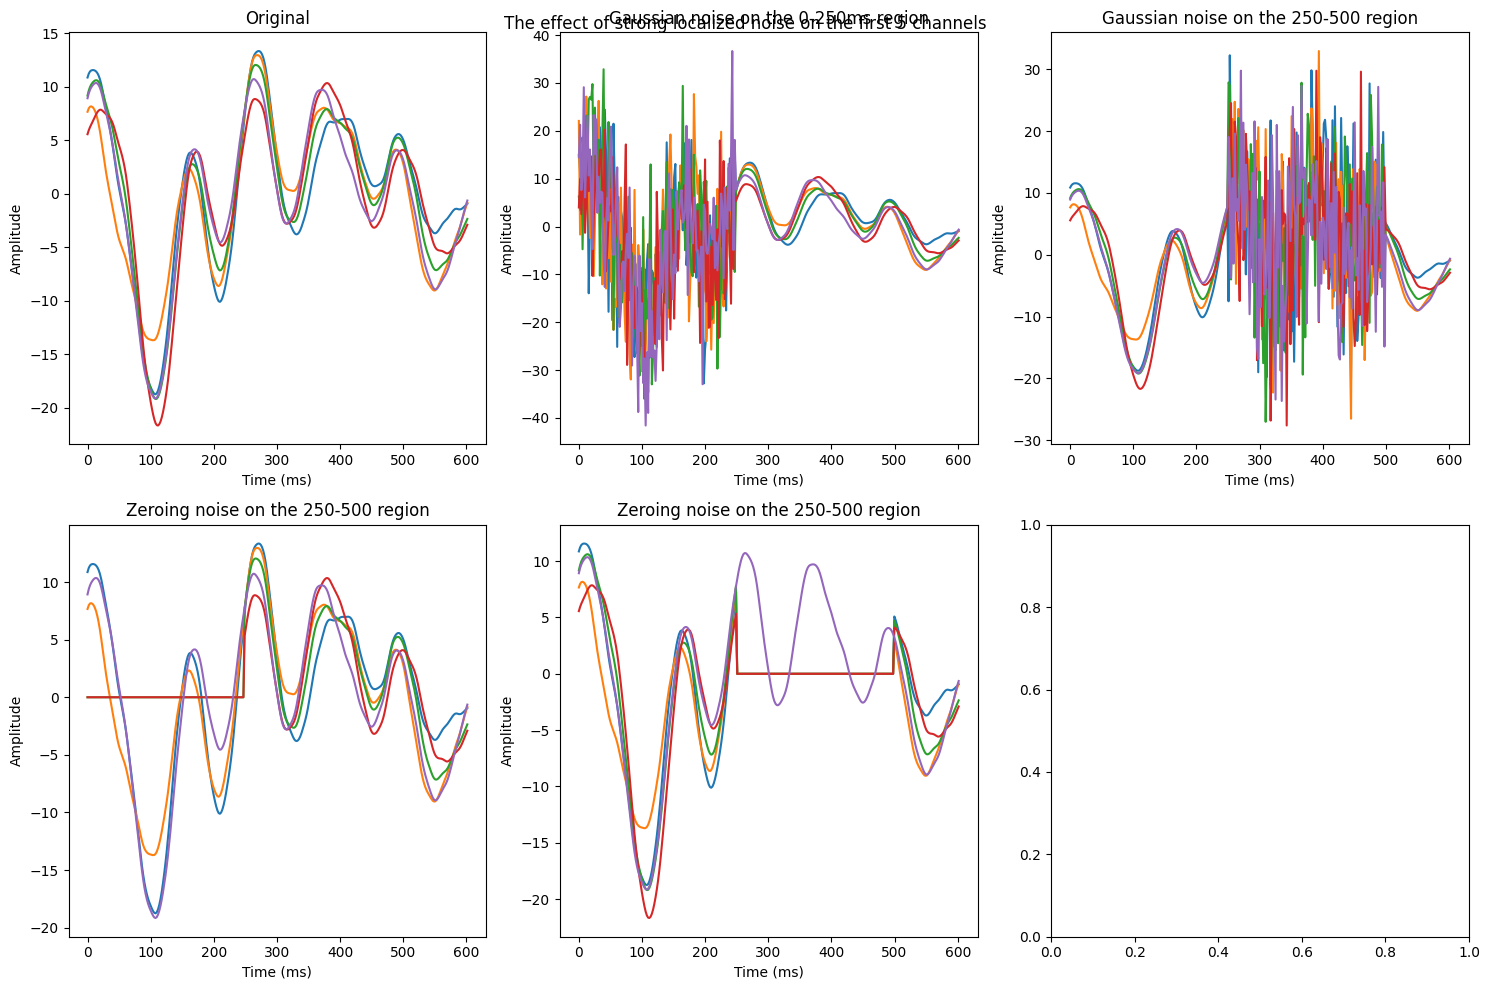

In [115]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
left_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_gaussian_noise = add_guassian_noise_to_dataset(train_copy, 10, low = 128, high = 255)

train_copy = copy.deepcopy(train)
left_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 0, high = 127)

train_copy = copy.deepcopy(train)
right_zeroing_noise = add_zero_to_dataset(train_copy, 10, low = 128, high = 255)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0][0].plot(t, train[0][0][0], label='1')
axes[0][0].plot(t, train[0][0][1], label='2')
axes[0][0].plot(t, train[0][0][2], label="3")
axes[0][0].plot(t, train[0][0][3], label="4")
axes[0][0].plot(t, train[0][0][4], label="5")
axes[0][0].set_xlabel("Time (ms)")
axes[0][0].set_ylabel("Amplitude")
axes[0][0].set_title("Original")

axes[0][1].plot(t, left_gaussian_noise[0][0][0], label='1')
axes[0][1].plot(t, left_gaussian_noise[0][0][1], label='2')
axes[0][1].plot(t, left_gaussian_noise[0][0][2], label="3")
axes[0][1].plot(t, left_gaussian_noise[0][0][3], label="4")
axes[0][1].plot(t, left_gaussian_noise[0][0][4], label="5")
axes[0][1].set_xlabel("Time (ms)")
axes[0][1].set_ylabel("Amplitude")
axes[0][1].set_title("Gaussian noise on the 0-250ms region")

axes[0][2].plot(t, right_gaussian_noise[0][0][0], label='1')
axes[0][2].plot(t, right_gaussian_noise[0][0][1], label='2')
axes[0][2].plot(t, right_gaussian_noise[0][0][2], label="3")
axes[0][2].plot(t, right_gaussian_noise[0][0][3], label="4")
axes[0][2].plot(t, right_gaussian_noise[0][0][4], label="5")
axes[0][2].set_xlabel("Time (ms)")
axes[0][2].set_ylabel("Amplitude")
axes[0][2].set_title("Gaussian noise on the 250-500 region")

axes[1][0].plot(t, left_zeroing_noise[0][0][0], label='1')
axes[1][0].plot(t, left_zeroing_noise[0][0][1], label='2')
axes[1][0].plot(t, left_zeroing_noise[0][0][2], label="3")
axes[1][0].plot(t, left_zeroing_noise[0][0][3], label="4")
axes[1][0].plot(t, left_zeroing_noise[0][0][4], label="5")
axes[1][0].set_xlabel("Time (ms)")
axes[1][0].set_ylabel("Amplitude")
axes[1][0].set_title("Zeroing noise on the 250-500 region")

axes[1][1].plot(t, right_zeroing_noise[0][0][0], label='1')
axes[1][1].plot(t, right_zeroing_noise[0][0][1], label='2')
axes[1][1].plot(t, right_zeroing_noise[0][0][2], label="3")
axes[1][1].plot(t, right_zeroing_noise[0][0][3], label="4")
axes[1][1].plot(t, right_zeroing_noise[0][0][4], label="5")
axes[1][1].set_xlabel("Time (ms)")
axes[1][1].set_ylabel("Amplitude")
axes[1][1].set_title("Zeroing noise on the 250-500 region")

figure.tight_layout()
figure.suptitle("The effect of strong localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [116]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_guassian_noise_to_dataset(train_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        val_copy = add_guassian_noise_to_dataset(val_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        test_copy = add_guassian_noise_to_dataset(test_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_gaussian.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_gaussian.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 432/432 [00:06<00:00, 71.11it/s, v_num=9acd]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:06<00:00, 70.71it/s, v_num=9acd]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (5.010931015014648, 50.82501983642578)
COMET INFO:     val_loss [1652]    : (3.6533923149108887, 49.36485290527344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.44 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET IN

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 91.14it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21995721442957364    │
│       incorrect_var       │    0.23979795534333745    │
│        overall_var        │    0.2226549909089717     │
│         test_acc          │    0.8582375645637512     │
│         test_loss         │    11.202301979064941     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21995721442957364
COMET INFO:     incorrect_var : 0.23979795534333745
COMET INFO:     overall_var   : 0.2226549909089717
COMET INFO:     test_acc      : 0.8582375645637512
COMET INFO:     test_loss     : 11.202301979064941
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.02it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 78.89it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (4.940971374511719, 55283.625)
COMET INFO:     val_loss [1652]    : (-1.2795054912567139, 68.74246978759766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 91.46it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.13127055366582746    │
│       incorrect_var       │    0.12952388214489927    │
│        overall_var        │    0.13100607030921513    │
│         test_acc          │     0.774904191493988     │
│         test_loss         │    18.838558197021484     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.13127055366582746
COMET INFO:     incorrect_var : 0.12952388214489927
COMET INFO:     overall_var   : 0.13100607030921513
COMET INFO:     test_acc      : 0.774904191493988
COMET INFO:     test_loss     : 18.838558197021484
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\ce828b01df1a4debbee4a61600c89acd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 79.73it/s, v_num=9acd]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 79.61it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (2.182469367980957, 49.07406234741211)
COMET INFO:     val_loss [1702]    : (5.016242980957031, 42.493675231933594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 504 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 87.18it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20678881644139216    │
│       incorrect_var       │    0.22716873101469592    │
│        overall_var        │    0.21189009503081993    │
│         test_acc          │    0.7388888597488403     │
│         test_loss         │    13.175877571105957     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20678881644139216
COMET INFO:     incorrect_var : 0.22716873101469592
COMET INFO:     overall_var   : 0.21189009503081993
COMET INFO:     test_acc      : 0.7388888597488403
COMET INFO:     test_loss     : 13.175877571105957
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 73.60it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 73.48it/s, v_num=9acd]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (2.182919502258301, 44.71294403076172)
COMET INFO:     val_loss [1702]    : (5.635013103485107, 46.067447662353516)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 86.56it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19946668828826425    │
│       incorrect_var       │    0.2282152401864251     │
│        overall_var        │    0.2057564330321771     │
│         test_acc          │     0.779629647731781     │
│         test_loss         │    11.862136840820312     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19946668828826425
COMET INFO:     incorrect_var : 0.2282152401864251
COMET INFO:     overall_var   : 0.2057564330321771
COMET INFO:     test_acc      : 0.779629647731781
COMET INFO:     test_loss     : 11.862136840820312
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\ce828b01df1a4debbee4a61600c89acd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 86.75it/s, v_num=9acd] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:04<00:00, 86.63it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (5.492542266845703, 56.45994186401367)
COMET INFO:     val_loss [1652]    : (5.336530685424805, 43.85811996459961)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 431 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 101.27it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 30.66it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21338393460018484    │
│       incorrect_var       │    0.2269763193303568     │
│        overall_var        │     0.218184427404956     │
│         test_acc          │    0.6505791544914246     │
│         test_loss         │    15.593302726745605     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21338393460018484
COMET INFO:     incorrect_var : 0.2269763193303568
COMET INFO:     overall_var   : 0.218184427404956
COMET INFO:     test_acc      : 0.6505791544914246
COMET INFO:     test_loss     : 15.593302726745605
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 77.86it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 429/429 [00:05<00:00, 77.72it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10725] : (5.718613624572754, 72.96670532226562)
COMET INFO:     val_loss [1652]    : (6.119254112243652, 48.657432556152344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 429 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 91.27it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2117431525048859     │
│       incorrect_var       │    0.22886033015948423    │
│        overall_var        │    0.21607417451455097    │
│         test_acc          │    0.7480695247650146     │
│         test_loss         │    13.351655006408691     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2117431525048859
COMET INFO:     incorrect_var : 0.22886033015948423
COMET INFO:     overall_var   : 0.21607417451455097
COMET INFO:     test_acc      : 0.7480695247650146
COMET INFO:     test_loss     : 13.351655006408691
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\ce828b01df1a4debbee4a61600c89acd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.95it/s, v_num=9acd]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.84it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.3815128803253174, 74.83177185058594)
COMET INFO:     val_loss [1677]    : (3.9273579120635986, 51.17731475830078)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 467 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which 

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 74.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 27.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1737636298348269     │
│       incorrect_var       │    0.21209798554387638    │
│        overall_var        │    0.18064526309163625    │
│         test_acc          │    0.8203421831130981     │
│         test_loss         │    10.824549674987793     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1737636298348269
COMET INFO:     incorrect_var : 0.21209798554387638
COMET INFO:     overall_var   : 0.18064526309163625
COMET INFO:     test_acc      : 0.8203421831130981
COMET INFO:     test_loss     : 10.824549674987793
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 75.94it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 75.78it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.158411979675293, 66.85098266601562)
COMET INFO:     val_loss [1677]    : (5.35990047454834, 46.836936950683594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 76.13it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 27.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.18960835518600302    │
│       incorrect_var       │    0.2138002623491112     │
│        overall_var        │    0.1946753872763861     │
│         test_acc          │    0.8051331043243408     │
│         test_loss         │    11.335119247436523     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.18960835518600302
COMET INFO:     incorrect_var : 0.2138002623491112
COMET INFO:     overall_var   : 0.1946753872763861
COMET INFO:     test_acc      : 0.8051331043243408
COMET INFO:     test_loss     : 11.335119247436523
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\ce828b01df1a4debbee4a61600c89acd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 77.39it/s, v_num=9acd]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 77.26it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (5.818052291870117, 46.617645263671875)
COMET INFO:     val_loss [1702]    : (1.6321909427642822, 48.47430419921875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 152 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, te

Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 91.02it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.18736110113295815    │
│       incorrect_var       │    0.2258346325846819     │
│        overall_var        │    0.19217814048810242    │
│         test_acc          │    0.8664292097091675     │
│         test_loss         │     9.207010269165039     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.18736110113295815
COMET INFO:     incorrect_var : 0.2258346325846819
COMET INFO:     overall_var   : 0.19217814048810242
COMET INFO:     test_acc      : 0.8664292097091675
COMET INFO:     test_loss     : 9.207010269165039
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 422/422 [00:06<00:00, 64.60it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:06<00:00, 64.50it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (4.723007678985596, 66.62158203125)
COMET INFO:     val_loss [1702]    : (2.024020195007324, 48.56538391113281)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 85.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 29.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20309739104814706    │
│       incorrect_var       │    0.2311768186204583     │
│        overall_var        │    0.20741056989238182    │
│         test_acc          │    0.8477293252944946     │
│         test_loss         │     10.3233003616333      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20309739104814706
COMET INFO:     incorrect_var : 0.2311768186204583
COMET INFO:     overall_var   : 0.20741056989238182
COMET INFO:     test_acc      : 0.8477293252944946
COMET INFO:     test_loss     : 10.3233003616333
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\ce828b01df1a4debbee4a61600c89acd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 424/424 [00:05<00:00, 79.29it/s, v_num=9acd]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:05<00:00, 79.17it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (4.241109848022461, 54.84114456176758)
COMET INFO:     val_loss [1677]    : (2.598149299621582, 51.77235412597656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 185 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on th

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 84.78it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21609455123465107    │
│       incorrect_var       │    0.2181907771708642     │
│        overall_var        │    0.21824921034073658    │
│         test_acc          │    0.3892922103404999     │
│         test_loss         │     23.67401695251465     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21609455123465107
COMET INFO:     incorrect_var : 0.2181907771708642
COMET INFO:     overall_var   : 0.21824921034073658
COMET INFO:     test_acc      : 0.3892922103404999
COMET INFO:     test_loss     : 23.67401695251465
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Epoch 24: 100%|██████████| 424/424 [00:06<00:00, 63.45it/s, v_num=9acd]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:06<00:00, 63.36it/s, v_num=9acd]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (4.294600009918213, 53.03471374511719)
COMET INFO:     val_loss [1677]    : (3.224433660507202, 48.330810546875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 85.50it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22123658776106772    │
│       incorrect_var       │    0.2246349180341439     │
│        overall_var        │    0.2223420175242013     │
│         test_acc          │    0.6188747882843018     │
│         test_loss         │    17.320049285888672     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ce828b01df1a4debbee4a61600c89acd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22123658776106772
COMET INFO:     incorrect_var : 0.2246349180341439
COMET INFO:     overall_var   : 0.2223420175242013
COMET INFO:     test_acc      : 0.6188747882843018
COMET INFO:     test_loss     : 17.320049285888672
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished5







In [108]:
# Currently, I don't check the SHAP values for the highest influence area, but rather take the theoratical location of highest influence, which happens at around 250-500ms

# 0-250ms for low effect
# 250-500ms for high effect

# Tests for medium noise(5) on the low effect region, and medium noise on the high effect region

variances = [[] for _ in range(2)]
accuracies = [[] for _ in range(2)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    for i in range(2):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_zero_to_dataset(train_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        val_copy = add_zero_to_dataset(val_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)
        test_copy = add_zero_to_dataset(test_copy, 10, low = i * 128, high = (i + 1) * 128 - 1)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/localized_variances_zeroed.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/localized_accuracies_zeroed.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 432/432 [00:04<00:00, 88.90it/s, v_num=f827] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:04<00:00, 88.78it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (6.307703971862793, 52.969451904296875)
COMET INFO:     val_loss [1677]    : (1.5891449451446533, 50.558738708496094)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 52 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 102.67it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.55it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21507029757432933    │
│       incorrect_var       │    0.23727630103176287    │
│        overall_var        │    0.21785174147493538    │
│         test_acc          │    0.8639847040176392     │
│         test_loss         │    10.500816345214844     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21507029757432933
COMET INFO:     incorrect_var : 0.23727630103176287
COMET INFO:     overall_var   : 0.21785174147493538
COMET INFO:     test_acc      : 0.8639847040176392
COMET INFO:     test_loss     : 10.500816345214844
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 77.49it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 77.36it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (5.83738899230957, 48.399635314941406)
COMET INFO:     val_loss [1677]    : (1.298804521560669, 43.745758056640625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 89.54it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22757446654262262    │
│       incorrect_var       │    0.24054272343311156    │
│        overall_var        │    0.23011797969140313    │
│         test_acc          │     0.795976996421814     │
│         test_loss         │    12.664955139160156     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22757446654262262
COMET INFO:     incorrect_var : 0.24054272343311156
COMET INFO:     overall_var   : 0.23011797969140313
COMET INFO:     test_acc      : 0.795976996421814
COMET INFO:     test_loss     : 12.664955139160156
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 72.40it/s, v_num=f827]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 72.30it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (3.427210807800293, 47.79719543457031)
COMET INFO:     val_loss [1702]    : (3.299741506576538, 81.37440490722656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 355 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which ma

Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 76.76it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 28.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19928625978616105    │
│       incorrect_var       │    0.22846891009867343    │
│        overall_var        │    0.20449792385377266    │
│         test_acc          │    0.8166666626930237     │
│         test_loss         │     11.14673137664795     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19928625978616105
COMET INFO:     incorrect_var : 0.22846891009867343
COMET INFO:     overall_var   : 0.20449792385377266
COMET INFO:     test_acc      : 0.8166666626930237
COMET INFO:     test_loss     : 11.14673137664795
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 79.38it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 425/425 [00:05<00:00, 79.26it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10625] : (7.784152984619141, 13832.4375)
COMET INFO:     val_loss [1702]    : (5.894824028015137, 56.883636474609375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 353 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 90.90it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24925853237749782    │
│       incorrect_var       │    0.24927914359030273    │
│        overall_var        │    0.2492888987892204     │
│         test_acc          │    0.7310185432434082     │
│         test_loss         │    15.798806190490723     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24925853237749782
COMET INFO:     incorrect_var : 0.24927914359030273
COMET INFO:     overall_var   : 0.2492888987892204
COMET INFO:     test_acc      : 0.7310185432434082
COMET INFO:     test_loss     : 15.798806190490723
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 74.37it/s, v_num=f827]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:05<00:00, 74.22it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (7.06866455078125, 33109.09375)
COMET INFO:     val_loss [1677]    : (6.5969696044921875, 63.879371643066406)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 393 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 66.75it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 25.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24829056707255415    │
│       incorrect_var       │    0.24864368541098655    │
│        overall_var        │    0.2483441004220353     │
│         test_acc          │    0.8166022896766663     │
│         test_loss         │    15.040188789367676     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24829056707255415
COMET INFO:     incorrect_var : 0.24864368541098655
COMET INFO:     overall_var   : 0.2483441004220353
COMET INFO:     test_acc      : 0.8166022896766663
COMET INFO:     test_loss     : 15.040188789367676
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 427/427 [00:06<00:00, 66.97it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:06<00:00, 66.87it/s, v_num=f827]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (5.867687702178955, 56.81073760986328)
COMET INFO:     val_loss [1677]    : (5.880182266235352, 46.45979690551758)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 81.97it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21244877468296397    │
│       incorrect_var       │    0.22738957328121875    │
│        overall_var        │    0.2166433472790428     │
│         test_acc          │    0.7229729890823364     │
│         test_loss         │    14.149251937866211     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21244877468296397
COMET INFO:     incorrect_var : 0.22738957328121875
COMET INFO:     overall_var   : 0.2166433472790428
COMET INFO:     test_acc      : 0.7229729890823364
COMET INFO:     test_loss     : 14.149251937866211
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 75.80it/s, v_num=f827]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 75.66it/s, v_num=f827]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (3.3278000354766846, 54.816383361816406)
COMET INFO:     val_loss [1702]    : (2.322873115539551, 48.8155517578125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\p

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 91.97it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19737492354851782    │
│       incorrect_var       │    0.22278626075280325    │
│        overall_var        │    0.20328150242000478    │
│         test_acc          │    0.7804182767868042     │
│         test_loss         │     11.95361042022705     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19737492354851782
COMET INFO:     incorrect_var : 0.22278626075280325
COMET INFO:     overall_var   : 0.20328150242000478
COMET INFO:     test_acc      : 0.7804182767868042
COMET INFO:     test_loss     : 11.95361042022705
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 79.22it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 79.05it/s, v_num=f827]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10750] : (5.466342926025391, 57.927490234375)
COMET INFO:     val_loss [1702]    : (4.086860179901123, 63.624786376953125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 19 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 86.50it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20119990908939153    │
│       incorrect_var       │    0.22532583711194054    │
│        overall_var        │    0.2056872164157747     │
│         test_acc          │    0.8051331043243408     │
│         test_loss         │    11.488192558288574     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20119990908939153
COMET INFO:     incorrect_var : 0.22532583711194054
COMET INFO:     overall_var   : 0.2056872164157747
COMET INFO:     test_acc      : 0.8051331043243408
COMET INFO:     test_loss     : 11.488192558288574
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 78.17it/s, v_num=f827]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 78.05it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (4.092585563659668, 48.25897979736328)
COMET INFO:     val_loss [1702]    : (0.8908960819244385, 52.554718017578125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 152 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is th

Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 87.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19474503757448347    │
│       incorrect_var       │    0.22912788182271243    │
│        overall_var        │    0.20058184261048148    │
│         test_acc          │    0.8272484540939331     │
│         test_loss         │    10.420974731445312     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19474503757448347
COMET INFO:     incorrect_var : 0.22912788182271243
COMET INFO:     overall_var   : 0.20058184261048148
COMET INFO:     test_acc      : 0.8272484540939331
COMET INFO:     test_loss     : 10.420974731445312
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 77.30it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 77.18it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (6.907197952270508, 158.0716094970703)
COMET INFO:     val_loss [1702]    : (1.4957687854766846, 46.56034851074219)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 151 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 89.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22999396558235993    │
│       incorrect_var       │    0.24030265445897592    │
│        overall_var        │    0.23200522840872262    │
│         test_acc          │    0.8156722784042358     │
│         test_loss         │    12.668994903564453     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22999396558235993
COMET INFO:     incorrect_var : 0.24030265445897592
COMET INFO:     overall_var   : 0.23200522840872262
COMET INFO:     test_acc      : 0.8156722784042358
COMET INFO:     test_loss     : 12.668994903564453
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\c1783696b96748518c7a96c67d27f827\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 79.45it/s, v_num=f827]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 79.32it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (4.317582130432129, 51.86139678955078)
COMET INFO:     val_loss [1652]    : (4.257465362548828, 55.59873962402344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may 

Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 90.73it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20742407009746888    │
│       incorrect_var       │    0.1979511583442558     │
│        overall_var        │    0.20239896428671592    │
│         test_acc          │    0.5226860046386719     │
│         test_loss         │     24.70370864868164     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20742407009746888
COMET INFO:     incorrect_var : 0.1979511583442558
COMET INFO:     overall_var   : 0.20239896428671592
COMET INFO:     test_acc      : 0.5226860046386719
COMET INFO:     test_loss     : 24.70370864868164
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 79.67it/s, v_num=f827]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 422/422 [00:05<00:00, 79.53it/s, v_num=f827]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10550] : (5.02381706237793, 54.3199462890625)
COMET INFO:     val_loss [1652]    : (3.4340057373046875, 48.505393981933594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 92.21it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2227970538979907     │
│       incorrect_var       │    0.22844368487702502    │
│        overall_var        │    0.22498962039063716    │
│         test_acc          │    0.5580762028694153     │
│         test_loss         │     17.7741756439209      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/c1783696b96748518c7a96c67d27f827
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2227970538979907
COMET INFO:     incorrect_var : 0.22844368487702502
COMET INFO:     overall_var   : 0.22498962039063716
COMET INFO:     test_acc      : 0.5580762028694153
COMET INFO:     test_loss     : 17.7741756439209
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished5







Text(0.5, 1.0, 'Effect of zeroing on accuracy')

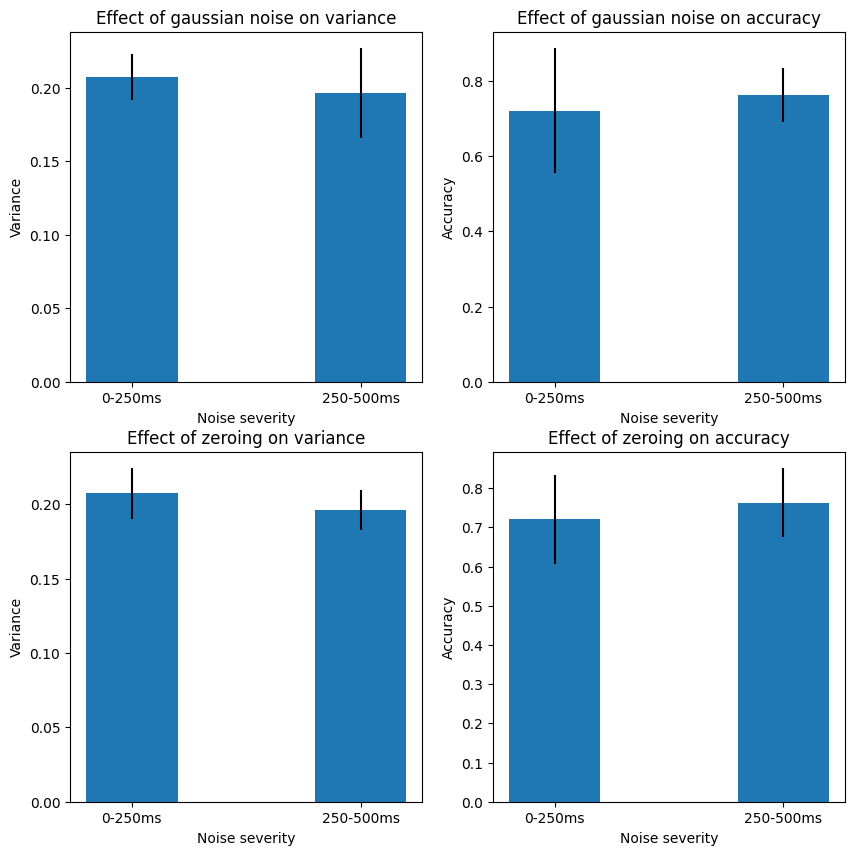

In [117]:
# Load in the .pkl files
with open('results_pickled/localized_accuracies_gaussian.pkl', 'rb') as f:
    accuracies_gaussian = pickle.load(f)

with open('results_pickled/localized_variances_gaussian.pkl', 'rb') as f:
    variances_gaussian = pickle.load(f)

with open('results_pickled/localized_accuracies_zeroed.pkl', 'rb') as f:
    accuracies_zeroed = pickle.load(f)

with open('results_pickled/localized_variances_zeroed.pkl', 'rb') as f:
    variances_zeroed = pickle.load(f)

standard_deviation_variances_gaussian = []
standard_deviation_accuracies_gaussian = []
standard_deviation_variances_zeroed = []
standard_deviation_accuracies_zeroed = []

# Take the mean of the accuracies and variances
for i in range(2):
    standard_deviation_variances_gaussian.append(np.asarray(variances_gaussian[i]).std())
    standard_deviation_accuracies_gaussian.append(np.asarray(accuracies_gaussian[i]).std())
    standard_deviation_variances_zeroed.append(np.asarray(variances_zeroed[i]).std())
    standard_deviation_accuracies_zeroed.append(np.asarray(accuracies_zeroed[i]).std())
    variances_gaussian[i] = np.asarray(variances[i]).mean()
    accuracies_gaussian[i] = np.asarray(accuracies[i]).mean()
    variances_zeroed[i] = np.asarray(variances[i]).mean()
    accuracies_zeroed[i] = np.asarray(accuracies[i]).mean()

# Create a barplot of the variances and accuracies
figure, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].bar(["0-250ms", "250-500ms"], variances_gaussian, yerr=standard_deviation_variances_gaussian, width = 0.4)
axes[0][0].set_xlabel("Noise severity")
axes[0][0].set_ylabel("Variance")
axes[0][0].set_title("Effect of gaussian noise on variance")
axes[0][1].bar(["0-250ms", "250-500ms"], accuracies_gaussian, yerr=standard_deviation_accuracies_gaussian, width = 0.4)
axes[0][1].set_xlabel("Noise severity")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].set_title("Effect of gaussian noise on accuracy")

axes[1][0].bar(["0-250ms", "250-500ms"], variances_zeroed, yerr=standard_deviation_variances_zeroed, width = 0.4)
axes[1][0].set_xlabel("Noise severity")
axes[1][0].set_ylabel("Variance")
axes[1][0].set_title("Effect of zeroing on variance")
axes[1][1].bar(["0-250ms", "250-500ms"], accuracies_zeroed, yerr=standard_deviation_accuracies_zeroed, width = 0.4)
axes[1][1].set_xlabel("Noise severity")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_title("Effect of zeroing on accuracy")

# As can be seen, there is practically no difference between the two noise locations
# Variance and accuracy are almost identical